In [1]:
#importing library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_curve,recall_score,classification_report,mean_squared_error,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
import datetime
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from Patel_Ruchit_Capstone_Project_Code import unique_feature
from Patel_Ruchit_Capstone_Project_Code import app_count
from Patel_Ruchit_Capstone_Project_Code import ip_analysis
from Patel_Ruchit_Capstone_Project_Code import app_analysis
from Patel_Ruchit_Capstone_Project_Code import os_analysis
from Patel_Ruchit_Capstone_Project_Code import device_analysis
from Patel_Ruchit_Capstone_Project_Code import channel_analysis
from Patel_Ruchit_Capstone_Project_Code import dailyhour_analysis
from Patel_Ruchit_Capstone_Project_Code import hour_analysis
from Patel_Ruchit_Capstone_Project_Code import load_data
from Patel_Ruchit_Capstone_Project_Code import data_cleaning
from Patel_Ruchit_Capstone_Project_Code import analysing_data
from Patel_Ruchit_Capstone_Project_Code import data_balancing
from Patel_Ruchit_Capstone_Project_Code import draw_roc
from Patel_Ruchit_Capstone_Project_Code import get_roc_test
%matplotlib inline

# Section 1.1 Data extraction from
https://www.kaggle.com/yuliagm/talkingdata-eda-plus-time-patterns/data
The purpose of this data is to see if the app was dowloaded from the link or not after the user clicked on the link

1.the data is collected for fraud detection from kaggle
2. Data set contains 8 variables
   1. ip: ip address of click.
   2. app: app id for marketing.
   3. device: device type id of user (eg ipad 1, Nexus, iphone 10).
   4. os: operating system version of user devices.
   5. channel: channel id of mobile ad publisher.
   6. click_time: time stamp (UTC).
   7. attribute_time: gives the time when user dowladed the app.
   8. is_attribute: indicating if the app was dowladed or not. (0= clicks not converted and 1= clicks converted)
    

##Research question
     1 what is the click convengerce rate of the dowloading app?
     2 what is the downloading rate of each features? (App, Device, IP, OS, Channel)
     3 what is the peak hour for the most click fraud?

In [2]:
# importing data
data= pd.read_csv("https://raw.githubusercontent.com/patelr4/TalkingData/master/train.csv")

In [3]:
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


# Section 1.2 Data preparation and data clean up
    1. Checking dataset shape and features
    2.seting the following integers;ip, app, device, os, channel into categorical variable for analyses.
    3.transforming attributed_time and click_time as time series
    4.deleting missing data

In [4]:
# checking dataset shape and features
print('Shape of dataset is:{}'.format(data.shape))
print('Type of features is:{}'.format(data.dtypes))

Shape of dataset is:(100000, 8)
Type of features is:ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
click_time         object
attributed_time    object
is_attributed       int64
dtype: object


In [5]:
#setting up ip,app,device,os,channel for categories
data['ip'] = data['ip'].astype('category')
data['app'] = data['app'].astype('category')
data['device'] = data['device'].astype('category')
data['os'] = data['os'].astype('category')
data['channel'] = data['channel'].astype('category')


In [6]:
#set click_time and attributed_time as timeseries
data['click_time'] = pd.to_datetime(data['click_time'])
data['attributed_time'] = pd.to_datetime(data['attributed_time'])

In [7]:
# empty column delete
del data['attributed_time']

# Section 1.3 Data Visualization

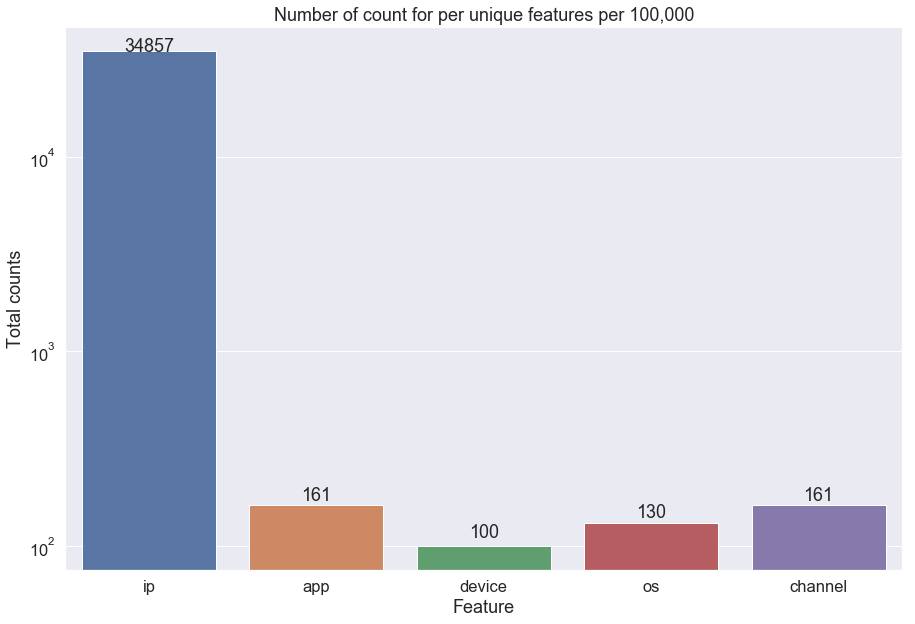

In [8]:
# Fig 1.3.1 plotting number of unique features per 100,00
unique_feature(data)

Fig 1.3.1 shows the total number of unique count enteries per features.
That means, we have total 34,857 unique IP addresses that gave data for fraud as well as non-fraud clicks

In [9]:
# Tab 1.3.2 counting number of time app downloaded 
data[['is_attributed']][data['is_attributed']==1].describe()

,is_attributed
count,227.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


Table 1.3.3 shows how many count actually get dowloaded. from the table we can observe only 227 app downloaded out of 100000 click count.

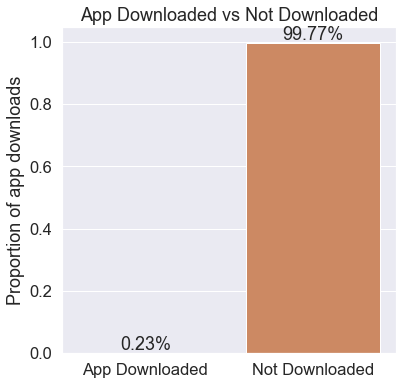

In [10]:
app_count(data)

FIG 1.3.4 shows how many clicks were dowladed vs not downloaded. For which we consider download attribute ==1 and not downloaded to ==0. From the bar plot x axis show downloaded and not dowloaded and Y axis shows the portion of click converted to dowload/non-dowload on scale of 0-1. we can observe only 0.23% click were convereted for dowload and 99.7% were just the click, which are not converted to download

In [11]:
#count of unique IP
ip_count_table = data['ip'].value_counts().reset_index(name='counts')
ip_count_table.columns = ['ip', 'counts']
ip_count_table[:15]

,ip,counts
0,5348,669
1,5314,616
2,73487,439
3,73516,399
4,53454,280
5,114276,219
6,26995,218
7,95766,205
8,17149,186
9,100275,173


In [12]:
data= data.merge(ip_count_table, on='ip', how='left')

In [13]:
data[data['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,is_attributed,counts
11680,5348,29,1,19,343,2017-11-07 23:07:12,1,669
15821,5348,19,0,29,213,2017-11-07 14:17:49,1,669
30073,5348,19,40,24,213,2017-11-09 10:47:39,1,669
88104,5314,83,0,21,171,2017-11-06 23:07:45,1,616
47464,5314,18,1,19,107,2017-11-08 12:23:04,1,616
78399,5314,10,1,1,113,2017-11-07 23:21:15,1,616
64677,111025,10,1,19,377,2017-11-07 13:45:35,1,137
22433,44067,19,0,38,213,2017-11-09 11:41:11,1,70
80075,5729,19,0,0,347,2017-11-07 07:33:23,1,42
9277,118252,19,957,59,213,2017-11-07 13:19:35,1,41


In [14]:
# detecting the total actual conversaion in dataset 
data[data['is_attributed']==1].ip.describe()

count      227
unique     223
top       5348
freq         3
Name: ip, dtype: int64

In [15]:
data['is_attributed']=data['is_attributed'].astype(int)

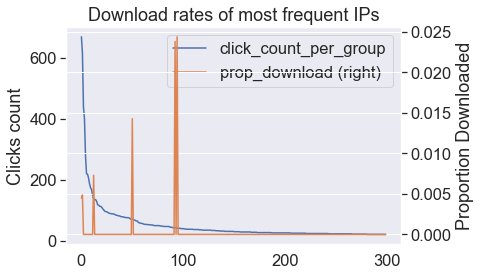

Download Rates over Counts of Most Popular IPs
        ip  click_count_per_group  prop_download
0     5348                    669       0.004484
1     5314                    616       0.004870
2    73487                    439       0.000000
3    73516                    399       0.000000
4    53454                    280       0.000000
5   114276                    219       0.000000
6    26995                    218       0.000000
7    95766                    205       0.000000
8    17149                    186       0.000000
9   100275                    173       0.000000
10  105475                    167       0.000000
11  105560                    149       0.000000
12  111025                    137       0.007299
13   43793                    135       0.000000
14   86767                    134       0.000000
15  137052                    128       0.000000
16    5178                    117       0.000000
17   49602                    116       0.000000
18   48282            

In [16]:
#plotting of top 100 popular IPs
ip_analysis(data)

Fig 1.3.5 we can see different IPs number of click on left y axis and on the right hand y axis tells the proportion of actually
downloaded. we can observe from table ip 5348 ip address is clicking 669 but their conversion rate is 0.004484, while IP address 
111025 clicked 137 times but their conversion rate is 0.7299. while others have 400, 280+ clicks and conversion rate is 0. So,
the fraud rate is higher and draws few IPs is setting more fraud.

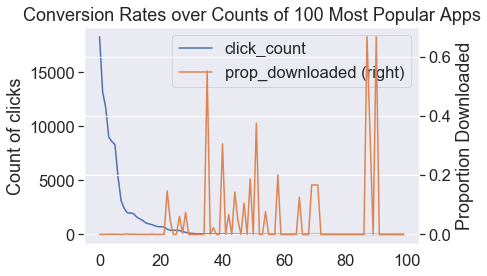

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0    3        18279         0.000219
1   12        13198         0.000076
2    2        11737         0.000000
3    9         8992         0.000890
4   15         8595         0.000233
5   18         8315         0.000601
6   14         5359         0.000000
7    1         3135         0.000000
8   13         2422         0.000000
9    8         2004         0.001996
10  21         1979         0.000000
11  11         1927         0.001038
12  26         1633         0.000000
13  23         1454         0.000000
14   6         1303         0.000000
15  64         1079         0.000000
16   7          981         0.000000
17  20          911         0.001098
18  25          804         0.000000
19  28          720         0.000000


In [17]:
#plotting of top 100 popular Apps
app_analysis(data)

Fig 1.3.6 Similarly, we can see different top 100 popular apps number of click on left y axis and on the right hand y axis tells the proportion of actually
downloaded. we can observe from table app 3 have 18279 click but their conversion rate for downloading is just 0.000219, while app 2 has 11,737 click count and their download proportion is 0.0000.  So, the fraud rate in app is more compare to IP.

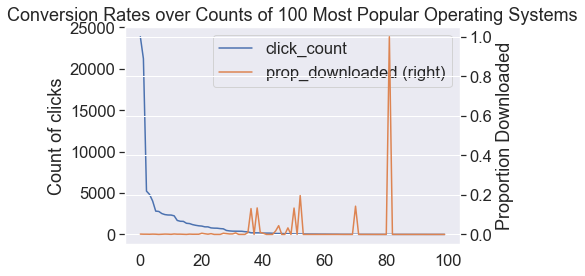

Counversion Rates over Counts of Most Popular Operating Systems
    os  click_count  prop_downloaded
0   19        23870         0.001718
1   13        21223         0.001178
2   17         5232         0.001147
3   18         4830         0.000828
4   22         4039         0.001486
5   10         2816         0.001065
6    8         2775         0.000000
7    6         2520         0.000794
8   15         2396         0.001669
9   20         2347         0.001278
10   9         2341         0.000427
11  25         2248         0.002224
12  16         1691         0.001183
13  37         1589         0.001259
14   3         1576         0.000635
15  41         1348         0.000000
16  14         1312         0.001524
17   1         1185         0.000844
18  12         1103         0.000907
19  23         1042         0.000960


In [18]:
#plotting of top 100 popular OS
os_analysis(data)

Fig 1.3.7 Similarly, we can see different top 100 popular OS number of clicks count on left of y axis and on the right side of 
y axis tells the proportion of actually downloaded. From the graph, we can observe that os 19 is having 23870 click but their 
conversion rate for downloading is just 0.001718,while OS 41 is having 1348 click count and their download proportion is 0.0000.
So, the fraud rate in lesser compare to App and IP. From the observation, we can also conclude more number of counts is having
better conversion proportion compare to IP and App.

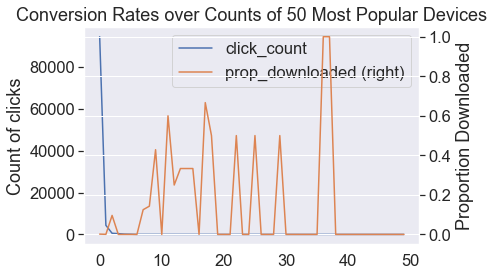

Count of clicks and proportion of downloads by device:
   device  click_count  prop_downloaded
0       1        94338         0.001548
1       2         4345         0.000460
2       0          541         0.096118
3    3032          371         0.000000
4    3543          151         0.000000
5    3866           93         0.000000
6      59           12         0.000000
7       6            8         0.125000
8      40            7         0.142857
9      16            7         0.428571
10      5            7         0.000000
11     97            5         0.600000
12     50            4         0.250000
13     33            3         0.333333
14     60            3         0.333333
15      4            3         0.333333
16     25            3         0.000000
17     21            3         0.666667
18     30            2         0.500000
19     67            2         0.000000


In [19]:
#plotting of top 50 popular devices
device_analysis(data)

Fig 1.3.8 in this graph it shows similar thing for top 50 popular devices, number of clicks count on left of y axis and on the right side of 
y axis tells the proportion of actually downloaded. From the graph, we can observe that device 1 is having 94338 click but their 
conversion rate for downloading is just 0.001548,while device 97 is having 5 click count and their download proportion is 0.600000.
So, the app downloading conversion rate in more consistant and efficient compare to App, OS and IP. From the observation.

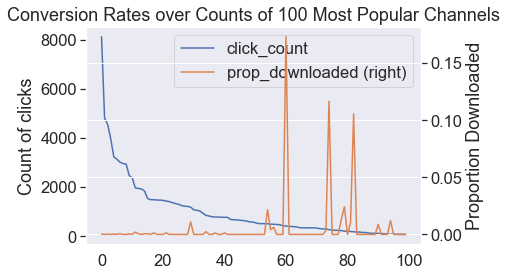

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      280         8114         0.000246
1      245         4802         0.000000
2      107         4543         0.000220
3      477         3960         0.000000
4      134         3224         0.000310
5      259         3130         0.000000
6      265         3013         0.000664
7      153         2954         0.000000
8      178         2936         0.000000
9      121         2472         0.000405
10     205         2369         0.000000
11     145         1964         0.002037
12     442         1941         0.000515
13     459         1921         0.000000
14     379         1833         0.000546
15     439         1528         0.000654
16     128         1486         0.000000
17     466         1483         0.001349
18     135         1473         0.000000
19     480         1468         0.000000


In [20]:
#bar plotting of top 100 popular channel
channel_analysis(data)

Fig 1.3.9 in this graph it shows the app conversation rate of top 100 channel, number of clicks count on left of y axis and on the right side of 
y axis tells the proportion of actually downloaded. From the graph, we can observe that channel 280 is having 8114 click but their 
conversion rate for downloading is just 0.000246,while channel 477 is having 3960 click count and their download proportion is 0.000.
So, the app downloading conversion rate in more better compare to App, OS, IPs but more fraud in devices.

In [21]:
time_analyses = pd.read_csv("https://raw.githubusercontent.com/patelr4/TalkingData/master/train.csv")
time_analyses.head(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [22]:
time_analyses['click_time'] = pd.to_datetime(time_analyses['click_time'])
time_analyses['attributed_time'] = pd.to_datetime(time_analyses['attributed_time'])

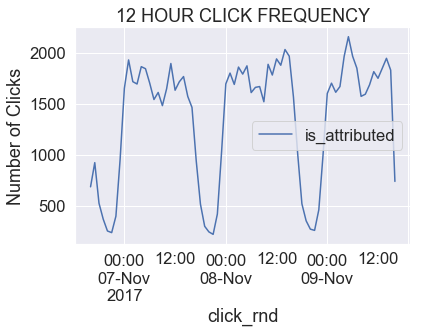

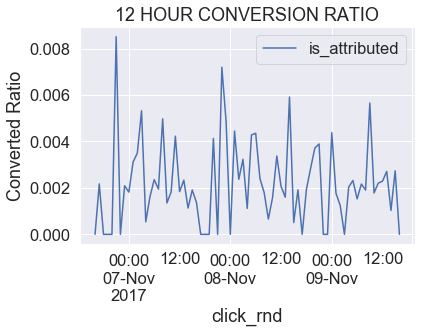

In [23]:
# Bar plot and line plot of number of hourly click vs every 12hours cycle
dailyhour_analysis(time_analyses)

Fig 1.3.10 shows the number of click counted on hourly bases in graph 1 and graph 2 shows the dowloading proportion. From the graph we can there is average 1500 to 2000
click every hour and another trend we can observe is the count goes drastically down in the morning time and drastically shoots up in
in the evening time. Other thing we can observe is the early morning dowloading conversion is more compare to the other time of the day.

In [24]:
time_analyses['click_hour']=time_analyses['click_time'].dt.hour

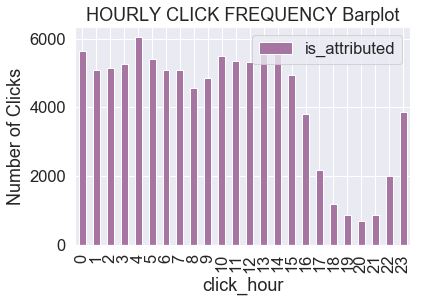

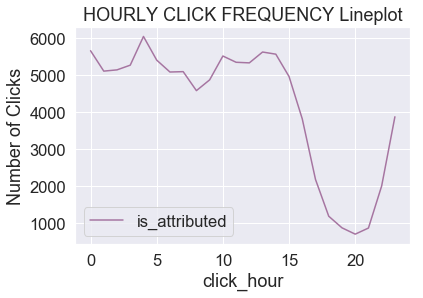

In [25]:
# Bar plot and line plot of number of hourly click vs hours
hour_analysis(time_analyses)

Fig 1.3.11 this two grap shows the number of clicks done every hour and from graphs, we can observe early morning 4.00 AM has most
click and 8.00 PM has least click.

# Section 1.4 Descriptive Analyses
From all the table and the graph, we can observe certain trend and pattern in the fraud. From the plots and tables, only 0.23% (227) app got downloaded out of 100,000 data and more number of click has no relation in higher convergence ratio of downloading. But compare to IPs, Channel and Apps; OS and Device has pretty consistent dowloading proportions. Based on Hourly and 12 hour day cycle, we observed the 4-5 PM has highest clicking count and lowest conversion ratio means the most fraud happens durring this time and lowest click is at 8.00 PM but conversion ratio is lower too. The only time count is less and conversion is more is in the early morning time. Thus the visual and other table answered all my research question to understand the trend and pattern about the fraud detection of application actually getting dowloaded or not. 

# Section 1.5 Predection

In [26]:
# importing data for prediction modeling
train, test = load_data()

In [27]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [28]:
test.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,173857,32,1,15,376,2017-11-08 14:01:25,NaN,0
1,189764,14,1,13,489,2017-11-07 00:01:09,NaN,0
2,5168,13,1,13,400,2017-11-09 08:47:27,NaN,0
3,87816,3,1,13,280,2017-11-07 05:14:28,NaN,0
4,5348,12,1,16,19,2017-11-08 12:05:14,NaN,0


In [29]:
#Cleaning and transforming both data sets
cleaned_train = data_cleaning(train)
cleaned_test = data_cleaning(test)

#checking true positive ratio in train data
print("Training data analysis")
analysing_data(cleaned_train)

# #checking true positive ratio in test data
print("Test data analysis")
analysing_data(cleaned_test)

balanced_train = data_balancing(cleaned_train)

print("Checking positive ratio in the balanced set:")
analysing_data(balanced_train)

Training data analysis
Number of rows in the dataset:  70000
Number of positive cases are 163
Positive data ratio is  0.23285714285714285 %
Test data analysis
Number of rows in the dataset:  30000
Number of positive cases are 64
Positive data ratio is  0.21333333333333335 %
Checking positive ratio in the balanced set:
Number of rows in the dataset:  326
Number of positive cases are 163
Positive data ratio is  50.0 %


Splitting  dataset into two parts for training and testing purposes 
1. traning data is stabilize by spiliting data 50-50% of conversion ratio
2. testing data is unstable because is splited in to 70% fraud click and 30% actual dowloaded data

auc is  0.8275718450645564
ROC curve for validation set for logistic regression


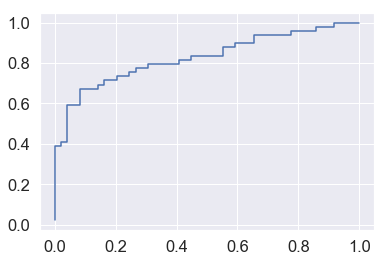

In [30]:
#building model for logistic regression
fit_model = LogisticRegression()
results = draw_roc(fit_model, balanced_train)
print("auc is " , results["roc_auc"])
print("ROC curve for validation set for logistic regression")
plt.plot(results["fpr"], 
          results["tpr"], results["lw"], results["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, results["roc_auc"]))

fig 1.5.1 in this graph Y-Axis is Postive rate and X-Axis is negative rate. The curve is made on training data showing 79%
prediction accuracy on stable (50/50%) split data.

model's auc on test set for logistic regression is  0.8514043501135755
ROC curve for test set for logistic regression


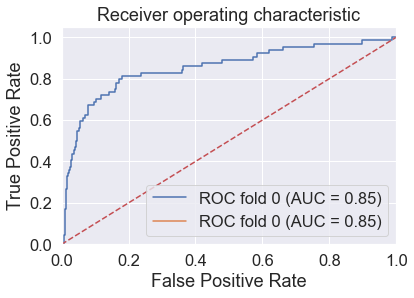

In [31]:
#Testing best model for logistic regression
test_lr = get_roc_test(results["model"], cleaned_test)
print("model's auc on test set for logistic regression is " , test_lr["roc_auc"])
print("ROC curve for test set for logistic regression")
plt.plot(test_lr["fpr"], 
          test_lr["tpr"], test_lr["lw"], test_lr["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, test_lr["roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

fig 1.5.2 in this graph Y-Axis is Postive rate and X-Axis is negative rate. The curve is made on testing data showing better
performance, by predicting the model accuracy rate of 83%. The prediction model performed better on testing data (70/30% split),
compare to training data.